# Ensemble Learning and Random Forests

If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an *ensemble*; thus this technique is called *Ensemble Learning*, and an Ensemble Learning Algorithm is called *Ensemble method*.

As an example of Ensemble method, you can train a group of Decision Tree classifiers, eacb on a different random subset of training set. to make predictions, you obtain the predictions of all the individual trees, and then predict the class that gets the most votes. This Ensemble is known as *Random Forests*.

Below, we will discuss the most popular Ensemble methods, including *bagging, boosting* and *stacking*, and explore *Random Forests*.

## Setup

In [37]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Voting Classifiers

In [38]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf), ('svc', svm_clf), ('rf', rf_clf),
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42))])

In [40]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, svm_clf, rf_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)    
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
SVC 0.87
RandomForestClassifier 0.88
VotingClassifier 0.87


#### Soft Voting

In [41]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf), ('svc', svm_clf), ('rf', rf_clf),
    ],
    voting='soft'
)

for clf in (log_clf, svm_clf, rf_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)    
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
SVC 0.87
RandomForestClassifier 0.88
VotingClassifier 0.89


## Bagging and Pasting

In both, bagging and pasting, the training instances are sampled several times across multiple predictors, but bagging 
allows sampling for the same predictor as well. This sampling when performed with *replacement* is called *bagging* while sampling *without replacement* is called *pasting*.

The below code trains an ensemble of 500 Decision Tree classifiers: each is trained on 100 training instances randomly sampled from the training set with replacement (to use pasting instead, set bootstrap=False). The n_jobs parameter tells how many CPU cores to use.

In [46]:
from sklearn.ensemble import BaggingClassifier

from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.9

In [87]:
bag_p_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=False, n_jobs=-1)

bag_p_clf.fit(X_train, y_train)

y_pred = bag_p_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.9

In [47]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.82


Saving figure decision_tree_without_and_with_bagging_plot


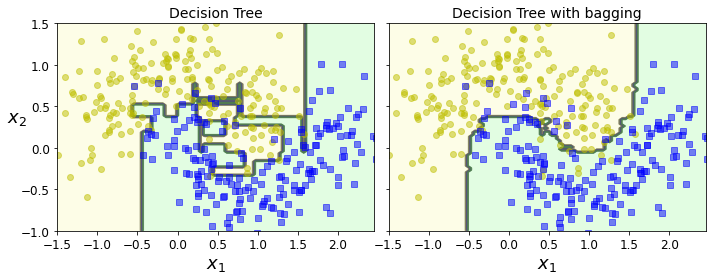

In [91]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)    
    x1, x2 = np.meshgrid(x1s, x2s)
    
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)

    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title('Decision Tree',fontsize=14)    

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.ylabel('')
plt.title('Decision Tree with bagging', fontsize=14)    

save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Random Forest